# Python Group
## Lab Assignment Five: Wide and Deep Network Architectures
### Wali Chaudhary, Bryce Shurts, & Alex Wright

#### Citation & Acknowledgement

Mushroom dataset https://www.kaggle.com/datasets/uciml/mushroom-classification

In [2]:
# Handle all imports for notebook
import pandas as pd
import seaborn as sns
from pandas import DataFrame
from copy import deepcopy
import numpy as np
from sklearn.preprocessing import LabelEncoder
from category_encoders import BinaryEncoder
from category_encoders import OrdinalEncoder
from category_encoders import OneHotEncoder

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics as mt
import pprint

from matplotlib import pyplot as plt

import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense, Activation, Input
from keras.models import Model
from keras.utils import plot_model
from keras.layers import Embedding
from keras.layers import concatenate
from imblearn.over_sampling import SVMSMOTE
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import random

print("Tensorflow version:", tf.__version__)
print("Keras version:", keras.__version__)

Tensorflow version: 2.10.0
Keras version: 2.10.0


In [3]:
df: DataFrame = pd.read_csv("mushrooms.csv")
df.head()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g


In [4]:
print(df.nunique())
print(df.info())

class                        2
cap-shape                    6
cap-surface                  4
cap-color                   10
bruises                      2
odor                         9
gill-attachment              2
gill-spacing                 2
gill-size                    2
gill-color                  12
stalk-shape                  2
stalk-root                   5
stalk-surface-above-ring     4
stalk-surface-below-ring     4
stalk-color-above-ring       9
stalk-color-below-ring       9
veil-type                    1
veil-color                   4
ring-number                  3
ring-type                    5
spore-print-color            9
population                   6
habitat                      7
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8124 entries, 0 to 8123
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   class                     8124 non-null   object
 1   

Before we start our preprocessing efforts, let's first make sure we don't have any invalid rows with bogus or missing data:

In [5]:
print("Missing entries: " + str(df.isna().sum().sum() > 0) + "; " + str(df.shape[0]) + " samples total.")
if df.isna().sum().sum() > 0:
    print("Removing samples with missing data...")
    df.dropna(inplace=True)
    print("Missing entries: " + str(df.isna().sum().sum() > 0) + "; " + str(df.shape[0]) + " samples total.")

Missing entries: False; 8124 samples total.


With that double-checked, let's begin by defining the variable which classification will be based around, and describe how we will represent each one of our datasets' variables. Thankfully, all the variables/features are categorical, meaning that our encoding of the features is relatively straightforward (at least, on the face of things).


In [6]:
for column in df.columns:
    num_values = df[column].nunique()
    if column == "population":
        print("'" + column + "' will be represented as a label-encoded (ordinal) integer")
    elif num_values == 2:
        print("'" + column + "' will be represented as a dummy-encoded bool/integer")
    elif 2 < num_values <= 5:
        print("'" + column + "' will be represented as a one-hot-encoded integer")
    elif num_values > 5:
        print("'" + column + "' will be represented as a binary-encoded integer")
    else: # 1 value
        print("'" + column + "' will be dropped")

'class' will be represented as a dummy-encoded bool/integer
'cap-shape' will be represented as a binary-encoded integer
'cap-surface' will be represented as a one-hot-encoded integer
'cap-color' will be represented as a binary-encoded integer
'bruises' will be represented as a dummy-encoded bool/integer
'odor' will be represented as a binary-encoded integer
'gill-attachment' will be represented as a dummy-encoded bool/integer
'gill-spacing' will be represented as a dummy-encoded bool/integer
'gill-size' will be represented as a dummy-encoded bool/integer
'gill-color' will be represented as a binary-encoded integer
'stalk-shape' will be represented as a dummy-encoded bool/integer
'stalk-root' will be represented as a one-hot-encoded integer
'stalk-surface-above-ring' will be represented as a one-hot-encoded integer
'stalk-surface-below-ring' will be represented as a one-hot-encoded integer
'stalk-color-above-ring' will be represented as a binary-encoded integer
'stalk-color-below-ring' 

Now we have a much better understanding of what we will be doing with our data. However, before we move forward with preprocessing work we will need to consider several salient factors. First and foremost, we want to avoid data leakage between our train and test sets, so anything that must be first fit/trained against to our data (e.g., the one-hot encoder) will need to take place after the dataset is split into a train and test set. Additionally, since our data is all categorical the encoding will explode our dimensionality: while we can combat it somewhat through binary encoding features that have a large number of possible values, we will still need to look at other methods like a kernel-based PCA for further reducing our dimensionality.

We will also want to take a look at a correlation matrix between our classification target, "class", and the rest of our variables, as we do not want to waste processor cycles on irrelevant data: this can be done after the encoding work but before PCA, so that we can limit the number of input features that need to be analyzed.

Therefore, we can begin with concerning the best way to split our data. First, let's see how balanced our target classes are.

In [7]:
print(df["class"].value_counts())
print("(" + df["class"][0] + ")" +str(round(df["class"].value_counts()[0]/df["class"].value_counts().sum(), 2)) + ":" + str(round(df["class"].value_counts()[1]/df["class"].value_counts().sum(), 2)) + "(" + df["class"][1] + ")")

e    4208
p    3916
Name: class, dtype: int64
(p)0.52:0.48(e)


This is pretty closed to being balanced already! Let's split out the target class from the rest of the dataset and use SVMSMOTE to balance things against the binary target class (directly encoding each category for each feature to a number so that SVMSMOTE can process it). From there we can do a quick validation to make sure that the generation went alright.

In [8]:
for column in df.select_dtypes(include=object).columns:
    df[column] = df[column].astype("category", copy=False).cat.codes
df_target = df["class"]
df.drop(columns=["class"], inplace=True)

smote = SVMSMOTE(random_state=42)
df_result, df_target_result = smote.fit_resample(df, df_target)
print(df_target_result.value_counts())

1    4208
0    4208
Name: class, dtype: int64


Perfect. Now, since we will be attempting to build multiple wide & deep networks to classify our data samples, we must also consider that each model will require hyperparameter optimization. This optimization, however, is susceptible to the same data leakage concern as our test set: we want to make sure we address this and ensure this validating step is free of bias from our dataset splitting process. Normally, such a task could be accomplished through a stratified hold-out method, although this is a generally inferior method (concerning bias) when compared to something like a stratified k-folds cross validation. Stratified shuffle split could also be used, however it leaves the possibility of excluding samples from the training & testing phases, and our dataset is small enough (<10,000 samples) that we would prefer to avoid this if possible.

As such, the k-folds method seems ideal, as its computational expensiveness is lessened by our relatively small dataset. We will use a stratified method, as we wish to preserve our 50/50 split / 1:1 ratio of each class in our binary classification target. Then, per the recommendations of Max Kuhn & Kjell Johnson in *Applied Predictive Modeling*, we will use a K = 10, to ensure a good estimate of model performance. While smaller values of K can result in a noisy estimate, this comes with the tradeoff of decreased variance: we can attempt to address this using PCA and keeping a sufficient number of components such that we can explain the vast majority of that variance.

Meaning that all told, we will split our dataset out into 2 sets, testing & training, using a stratified hold-out method in the traditional 80/20 ratio, and then apply stratified K-fold to the training test to generate a set of training & validating datasets. This should preserve our class distribution, give us a good base model to train & validate on, and still make it accessible to separately apply all of our preprocessing steps without incurring data leakage that might come from a more wholesale application.

In [9]:
train_samples, test_samples, train_target, test_target = train_test_split(df, df_target, train_size=0.8, test_size=0.2, stratify=df_target)

data_splits = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
dataset = data_splits.split(train_samples, train_target)
print("Number of splits:", data_splits.get_n_splits())

result = next(dataset)
# result[0][0] = in the given split, give me the first sample in the first fold, e.g.,
# SPLIT[FOLD][SAMPLE_INDEX]
print(train_samples.iloc[result[0][0]])
print(train_target.iloc[result[0][0]])


Number of splits: 10
cap-shape                   5
cap-surface                 3
cap-color                   8
bruises                     0
odor                        5
gill-attachment             1
gill-spacing                0
gill-size                   1
gill-color                  7
stalk-shape                 0
stalk-root                  0
stalk-surface-above-ring    2
stalk-surface-below-ring    0
stalk-color-above-ring      7
stalk-color-below-ring      7
veil-type                   0
veil-color                  2
ring-number                 1
ring-type                   1
spore-print-color           1
population                  5
habitat                     0
Name: 5997, dtype: int8
0


Great! Now we can start doing all the preprocessing that we mentioned earlier...

In [10]:
for column in train_samples:
    num_values = train_samples[column].nunique()
    if column == "population":
        ordinal_encoder = OrdinalEncoder(cols=[column], return_df=True)
        train_samples = ordinal_encoder.fit_transform(train_samples)
        test_samples = ordinal_encoder.transform(test_samples)
    elif num_values == 2:
        train_samples = pd.get_dummies(data=train_samples, drop_first=True)
        train_samples.drop(columns=[column], axis=1, inplace=True)
        test_samples = pd.get_dummies(data=test_samples, drop_first=True)
        test_samples.drop(columns=[column], axis=1, inplace=True)
    elif 2 < num_values <= 5:
        one_hot_encoder = OneHotEncoder(cols=[column], return_df=True)
        train_samples = one_hot_encoder.fit_transform(train_samples)
        test_samples = one_hot_encoder.transform(test_samples)
    elif num_values > 5:
        binary_encoder = BinaryEncoder(cols=[column], return_df=True)
        train_samples = binary_encoder.fit_transform(train_samples)
        test_samples = binary_encoder.transform(test_samples)
    else: # 1 value
        train_samples.drop(columns=[column], axis=1, inplace=True)
        test_samples.drop(columns=[column], axis=1, inplace=True)
train_samples.head()

,cap-shape_0,cap-shape_1,cap-shape_2,cap-surface_1,cap-surface_2,cap-surface_3,cap-surface_4,cap-color_0,cap-color_1,cap-color_2,...,ring-type_4,ring-type_5,spore-print-color_0,spore-print-color_1,spore-print-color_2,spore-print-color_3,population,habitat_0,habitat_1,habitat_2
5997,0,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,1,1,0,0,1
5679,0,0,1,1,0,0,0,0,0,1,...,0,0,0,0,1,0,2,0,1,0
2228,0,0,1,1,0,0,0,0,0,1,...,0,0,0,0,1,1,1,0,0,1
1722,0,0,1,0,1,0,0,0,0,1,...,0,0,0,1,0,0,3,0,1,1
4029,0,0,1,1,0,0,0,0,0,1,...,1,0,0,0,0,1,4,0,0,1


With that out of the way, we can now consider crossing certain columns whose relationship make prove to be a useful point for training. To determine this, and the general correlation of our features to our classification target, we will examine a correlation matrix. We want to see which variables are mostly tightly correlated with each other's existences, so we'll look at Pearson's correlation:

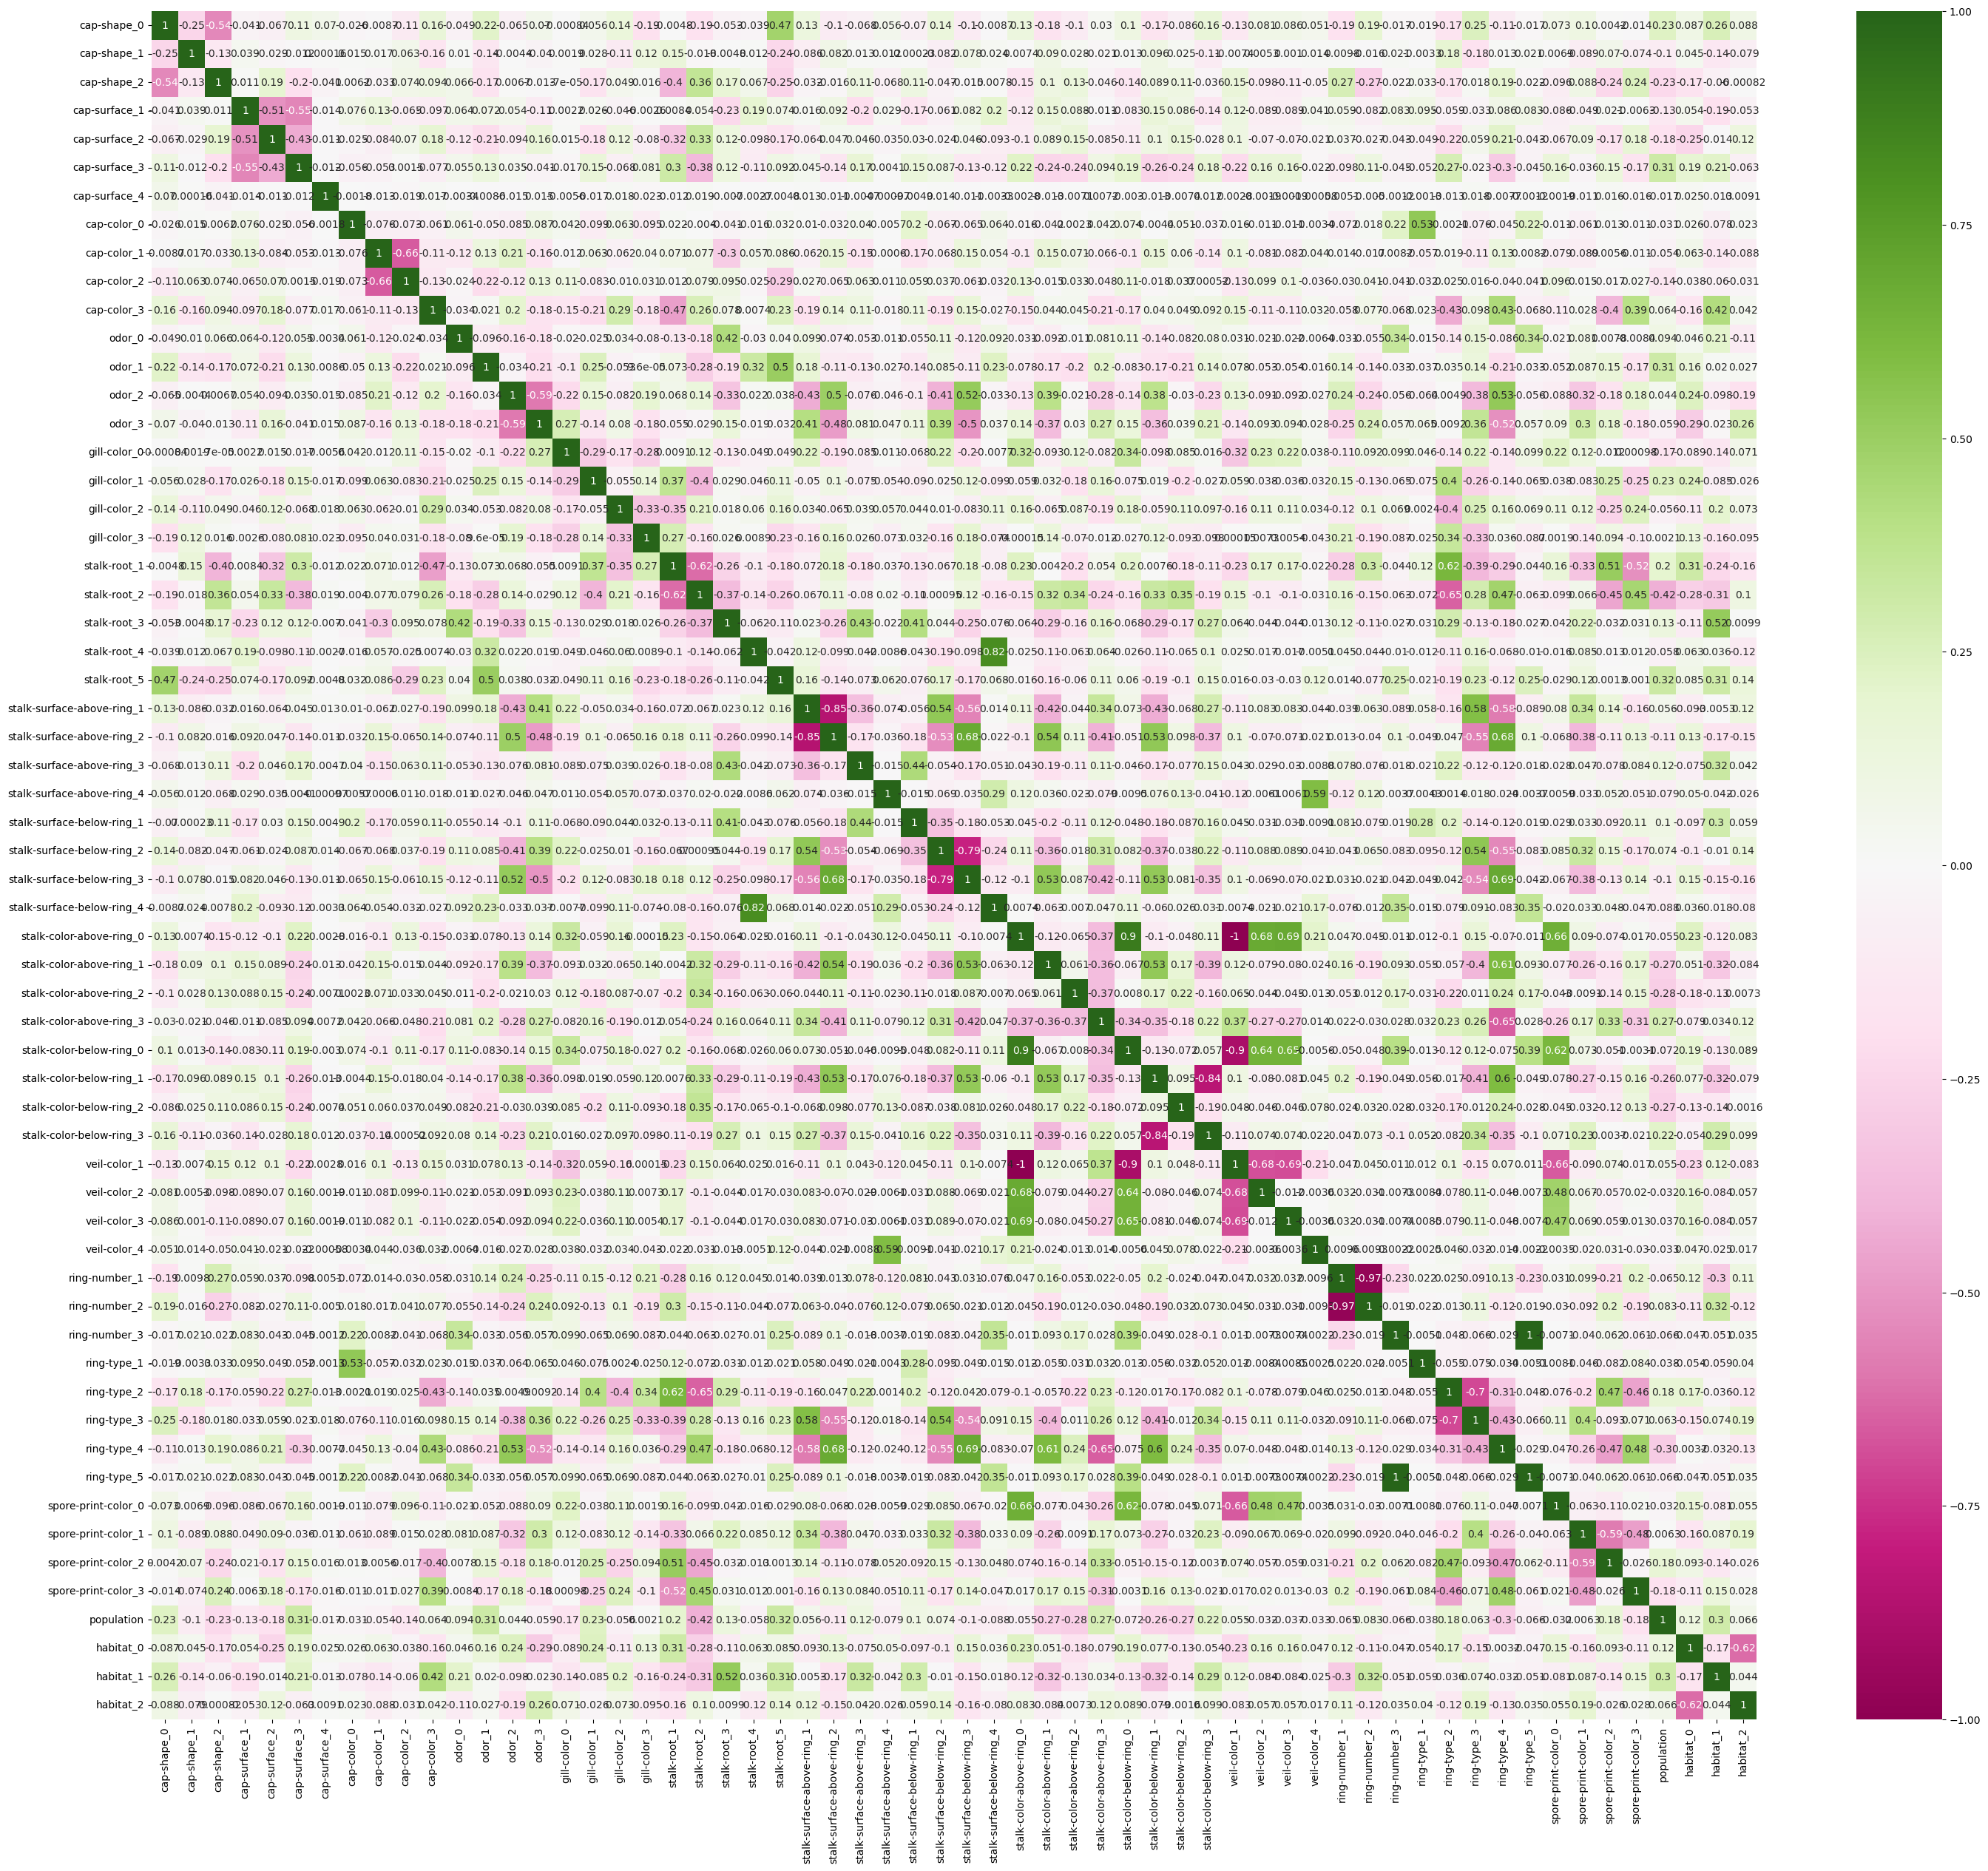

In [11]:
# correlation matrix
plt.figure(figsize=(35,30))
sns.heatmap(train_samples.corr(method="pearson"), annot=True, cmap='PiYG')
plt.show()

With how our matrix is set up, features that end up forming brightly-colored boxes and/or lines will represent those that are related: for instance, we can see that certain ring types are strongly related to certain stalk roots, which tells us that those features in combination may be significant. Other examples exist as well, like veil color and spore print color, or the stalk surface being above the ring and the ring type. Keeping this in mind, we can go through each set of related features and cross them together, providing us with aggregated features that, while not selected through expert domain knowledge, still represent a mathematically-supported linear relationship with each other.

In [12]:
cross_columns = [['veil-color_1', 'veil-color_2',
                  'veil-color_3', 'veil-color_4', 'spore-print-color_0',
                  'spore-print-color_1', 'spore-print-color_2', 'spore-print-color_3'],
                 ['stalk-surface-above-ring_1',
                  'stalk-surface-above-ring_2', 'stalk-surface-above-ring_3',
                  'stalk-surface-above-ring_4', 'ring-type_1', 'ring-type_2', 'ring-type_3',
                  'ring-type_4', 'ring-type_5'],
                 ['stalk-surface-below-ring_1',
                  'stalk-surface-below-ring_2', 'stalk-surface-below-ring_3',
                  'stalk-surface-below-ring_4', 'ring-type_1', 'ring-type_2', 'ring-type_3',
                  'ring-type_4', 'ring-type_5'],
                 ['stalk-root_1', 'stalk-root_2', 'stalk-root_3',
                  'stalk-root_4', 'stalk-root_5', 'ring-type_1', 'ring-type_2', 'ring-type_3',
                  'ring-type_4', 'ring-type_5'],
                 ['stalk-root_1', 'stalk-root_2', 'stalk-root_3',
                  'stalk-root_4', 'stalk-root_5', 'spore-print-color_0',
                  'spore-print-color_1', 'spore-print-color_2', 'spore-print-color_3']
]

# cross each set of columns in the list above
cross_col_df_names = []
for cols_list in cross_columns:
    # encode as ints for the embedding
    enc = LabelEncoder()

    # 1. create crossed labels by join operation
    X_crossed_train = train_samples[cols_list].apply(lambda x: '__'.join(str(x)), axis=1)
    X_crossed_test = test_samples[cols_list].apply(lambda x: '__'.join(str(x)), axis=1)

    # get a nice name for this new crossed column
    cross_col_name = '__'.join(cols_list)

    # 2. encode as integers, stacking all possibilities
    enc.fit(np.hstack((X_crossed_train.to_numpy(),  X_crossed_test.to_numpy())))

    # 3. Save into dataframe with new name
    train_samples[cross_col_name] = enc.transform(X_crossed_train)
    test_samples[cross_col_name] = enc.transform(X_crossed_test)

    # keep track of the new names of the crossed columns
    cross_col_df_names.append(cross_col_name)

print(cross_col_df_names)

['veil-color_1__veil-color_2__veil-color_3__veil-color_4__spore-print-color_0__spore-print-color_1__spore-print-color_2__spore-print-color_3', 'stalk-surface-above-ring_1__stalk-surface-above-ring_2__stalk-surface-above-ring_3__stalk-surface-above-ring_4__ring-type_1__ring-type_2__ring-type_3__ring-type_4__ring-type_5', 'stalk-surface-below-ring_1__stalk-surface-below-ring_2__stalk-surface-below-ring_3__stalk-surface-below-ring_4__ring-type_1__ring-type_2__ring-type_3__ring-type_4__ring-type_5', 'stalk-root_1__stalk-root_2__stalk-root_3__stalk-root_4__stalk-root_5__ring-type_1__ring-type_2__ring-type_3__ring-type_4__ring-type_5', 'stalk-root_1__stalk-root_2__stalk-root_3__stalk-root_4__stalk-root_5__spore-print-color_0__spore-print-color_1__spore-print-color_2__spore-print-color_3']


Now that we have a set of crossed features, let's check to see if we have any features that do not explain the classification target, which we can therefore remove to eliminate noise during the PCA.

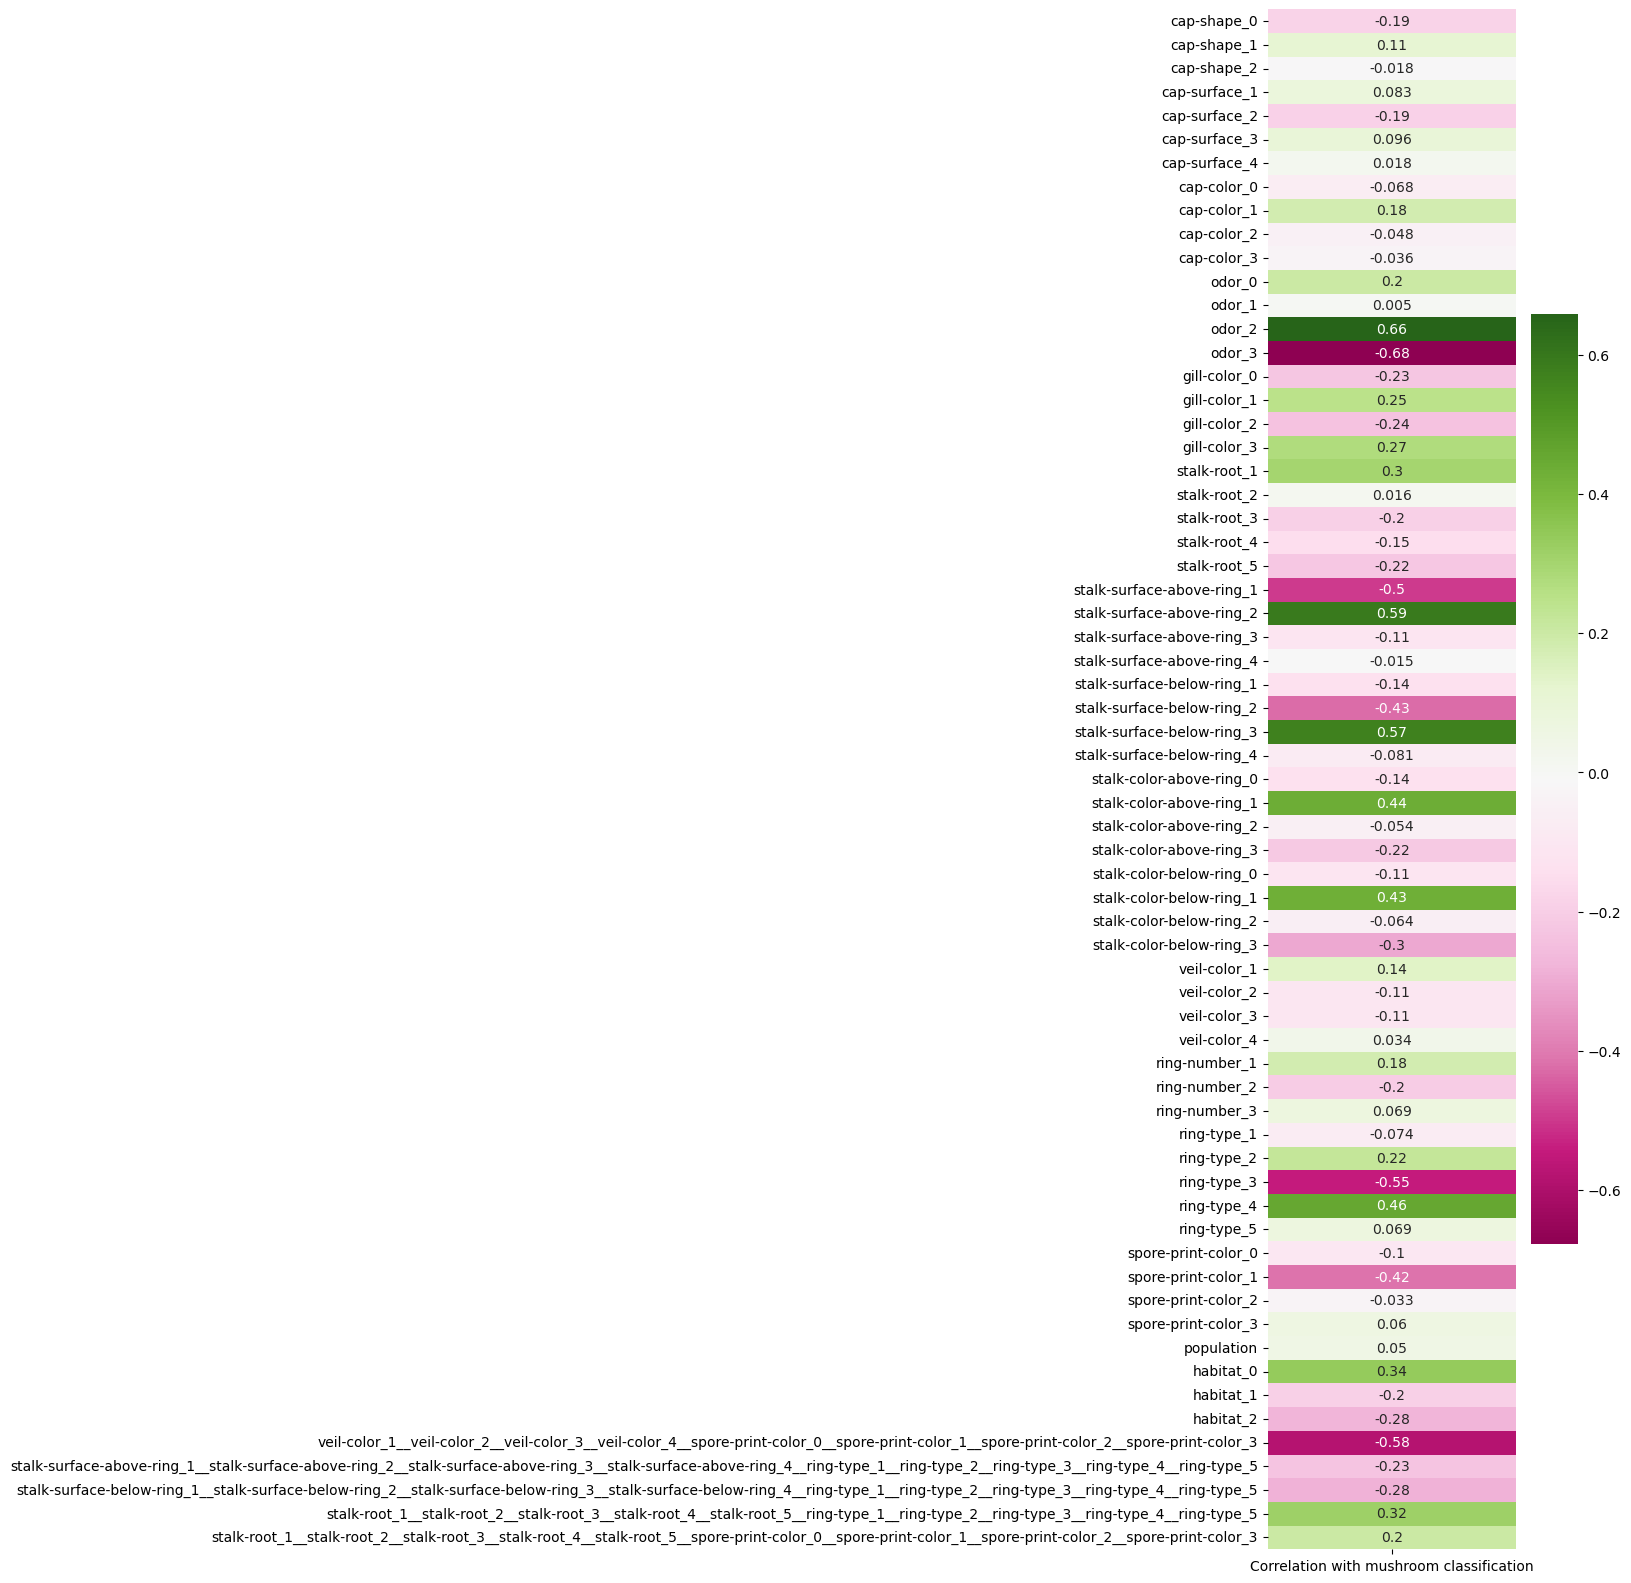

In [13]:
plt.figure(figsize=(4,20))
sns.heatmap(train_samples.corrwith(train_target, method="pearson").to_frame("Correlation with mushroom classification"), annot=True, cmap='PiYG')
plt.show()

It appears that our feature crossing was successful, with several of the new composite features providing a >|.5| correlation with our classification target! However, there are a number of features that are providing <|0.05| correlation, which can safely be removed to assist the PCA in finding relevant components.

In [14]:
train_samples.drop(columns=["cap-shape_2", "cap-surface_4", "cap-color_0", "cap-color_1", "odor_3", "gill-color_1", "stalk-surface-above-ring_4", "veil-color_4", "spore-print-color_0", "spore-print-color_3", "stalk-root_1"], axis=1, inplace=True)
test_samples.drop(columns=["cap-shape_2", "cap-surface_4", "cap-color_0", "cap-color_1", "odor_3", "gill-color_1", "stalk-surface-above-ring_4", "veil-color_4", "spore-print-color_0", "spore-print-color_3", "stalk-root_1"], axis=1, inplace=True)

Speaking of PCA, we need to ensure that we apply the appropriate form of PCA: most notably, we must understand if our data is linearly separable, or risk applying an irrelevant PCA kernel onto our data and ruining the hard work we have put into data preprocessing thus far.

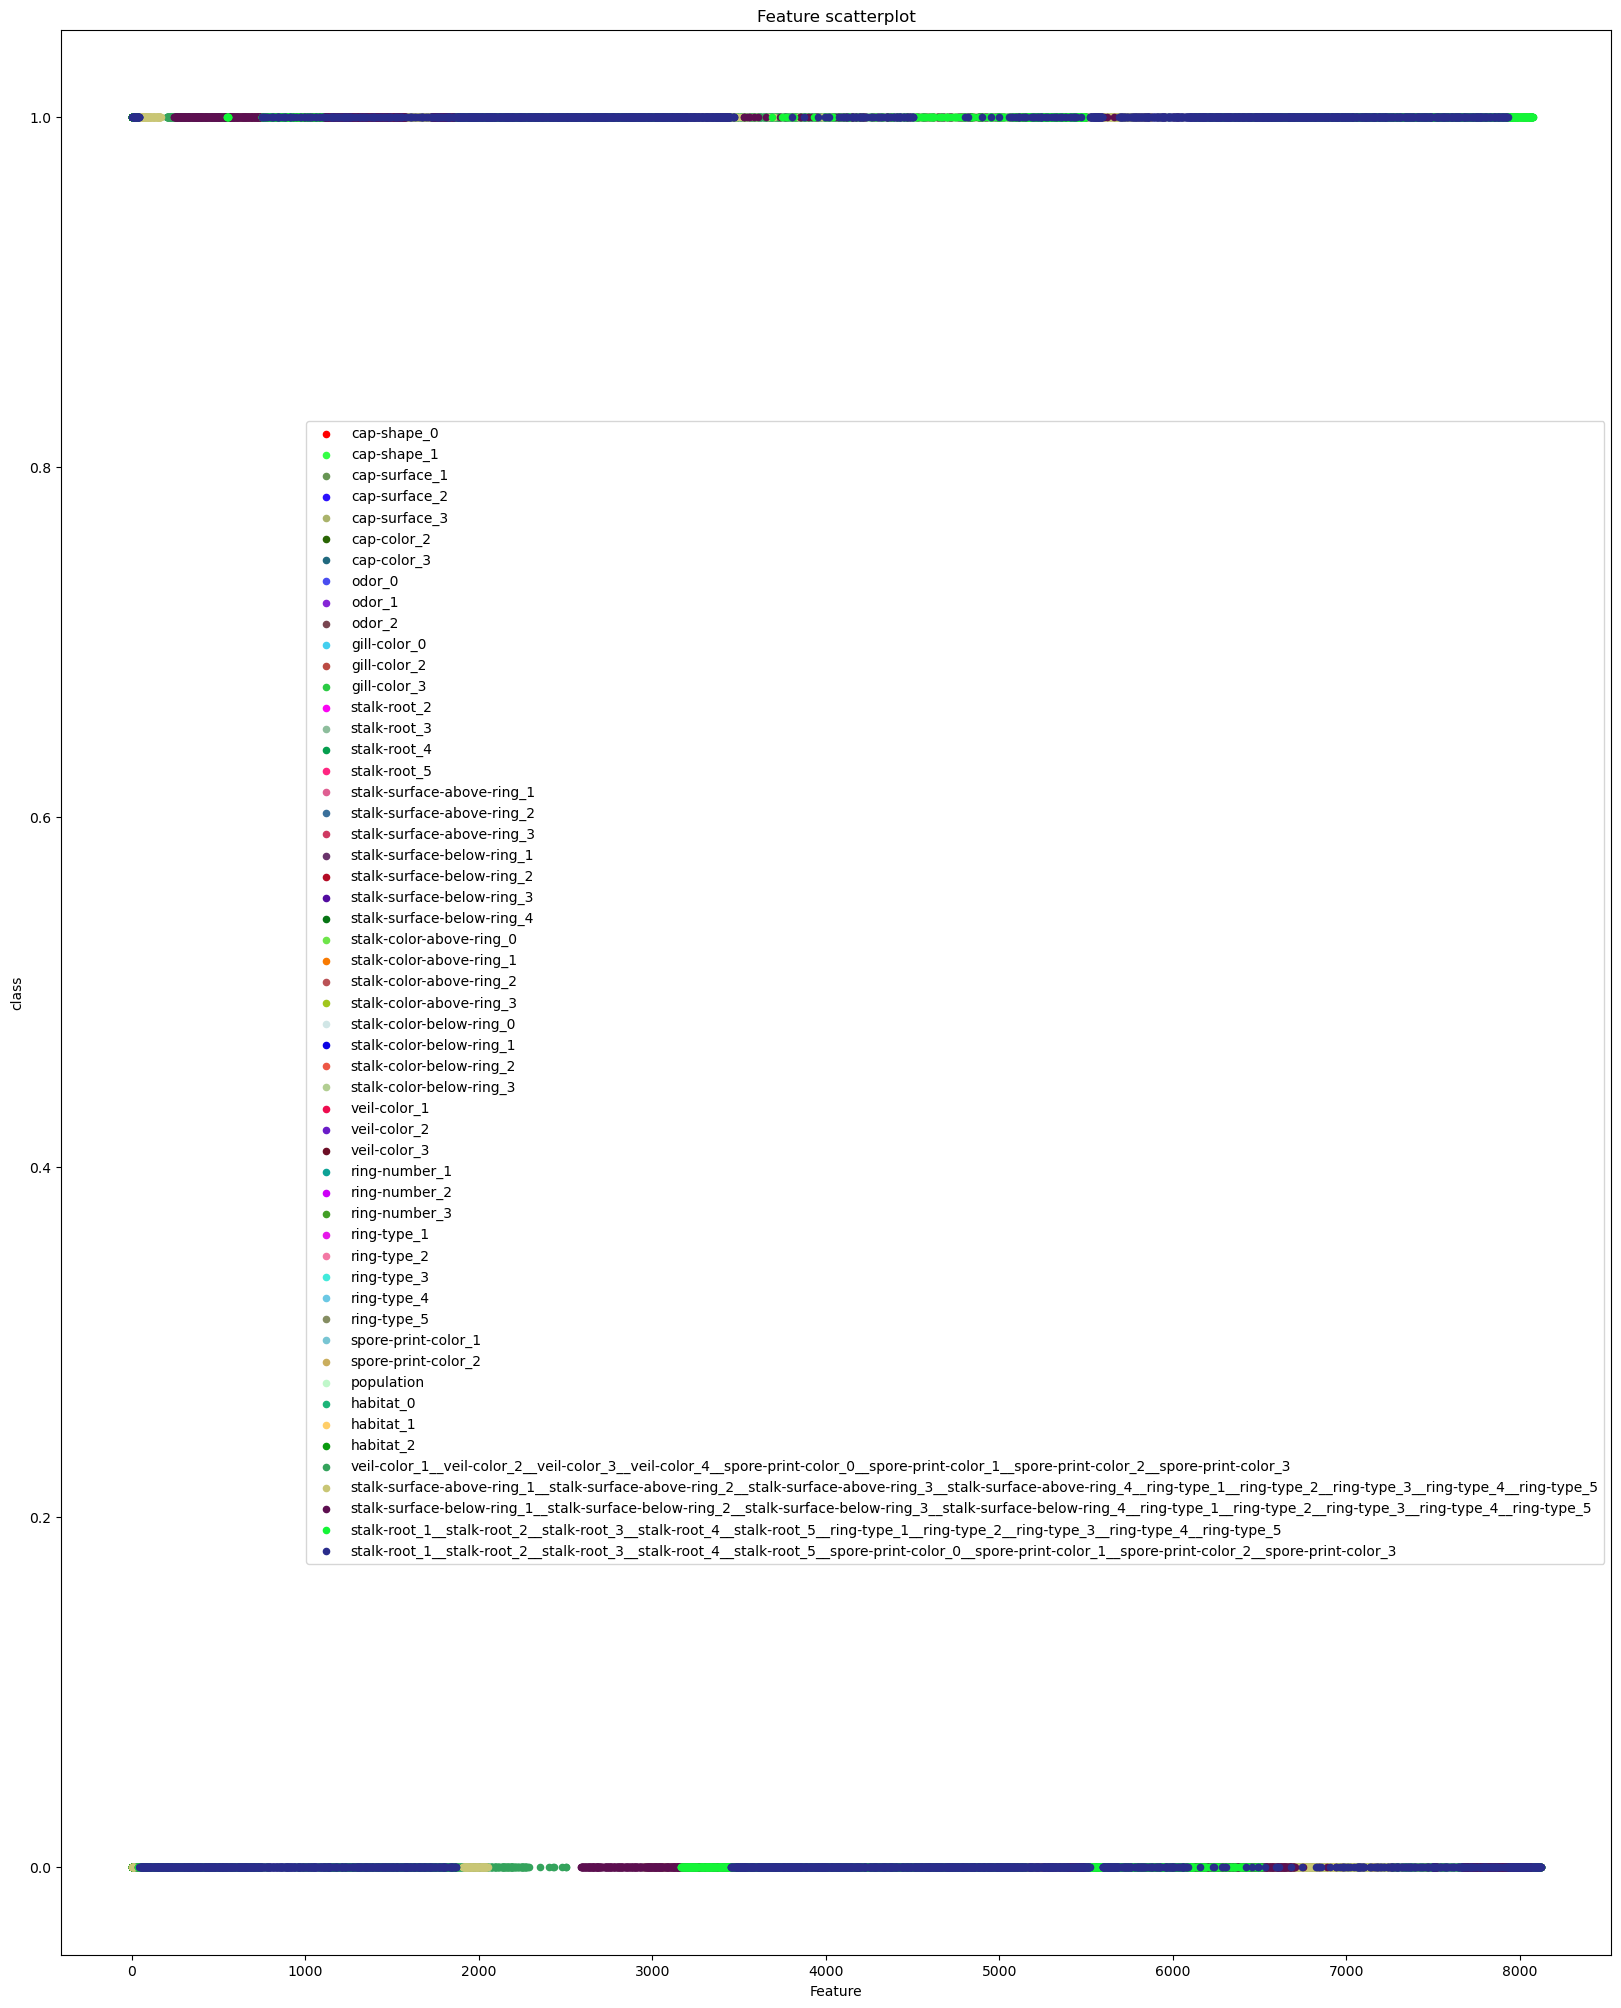

In [15]:
train_samples["class"] = train_target
axis = train_samples.plot.scatter(x="cap-shape_0", y="class", label="cap-shape_0", color="r", figsize=(20,25))

for column in train_samples.columns[1:]:
    if column == "class":
        continue
    color = (random.random(), random.random(), random.random())
    train_samples.plot.scatter(x=column, y="class", label=column, color=color, ax=axis)
axis.set_xlabel("Feature")
axis.set_title("Feature scatterplot")
plt.show()

train_samples.drop(columns=["class"], axis=1, inplace=True)

Based on the graph above, the data represents a relationship where each classification of data can be separated with a straight line, meaning a linear PCA-based decomposition should be able to accurately separate the data. With our data otherwise being preprocessed, we can now apply the PCA and evaluate whether it is able to detect meaningful components and successfully explain the variance of our dataset:

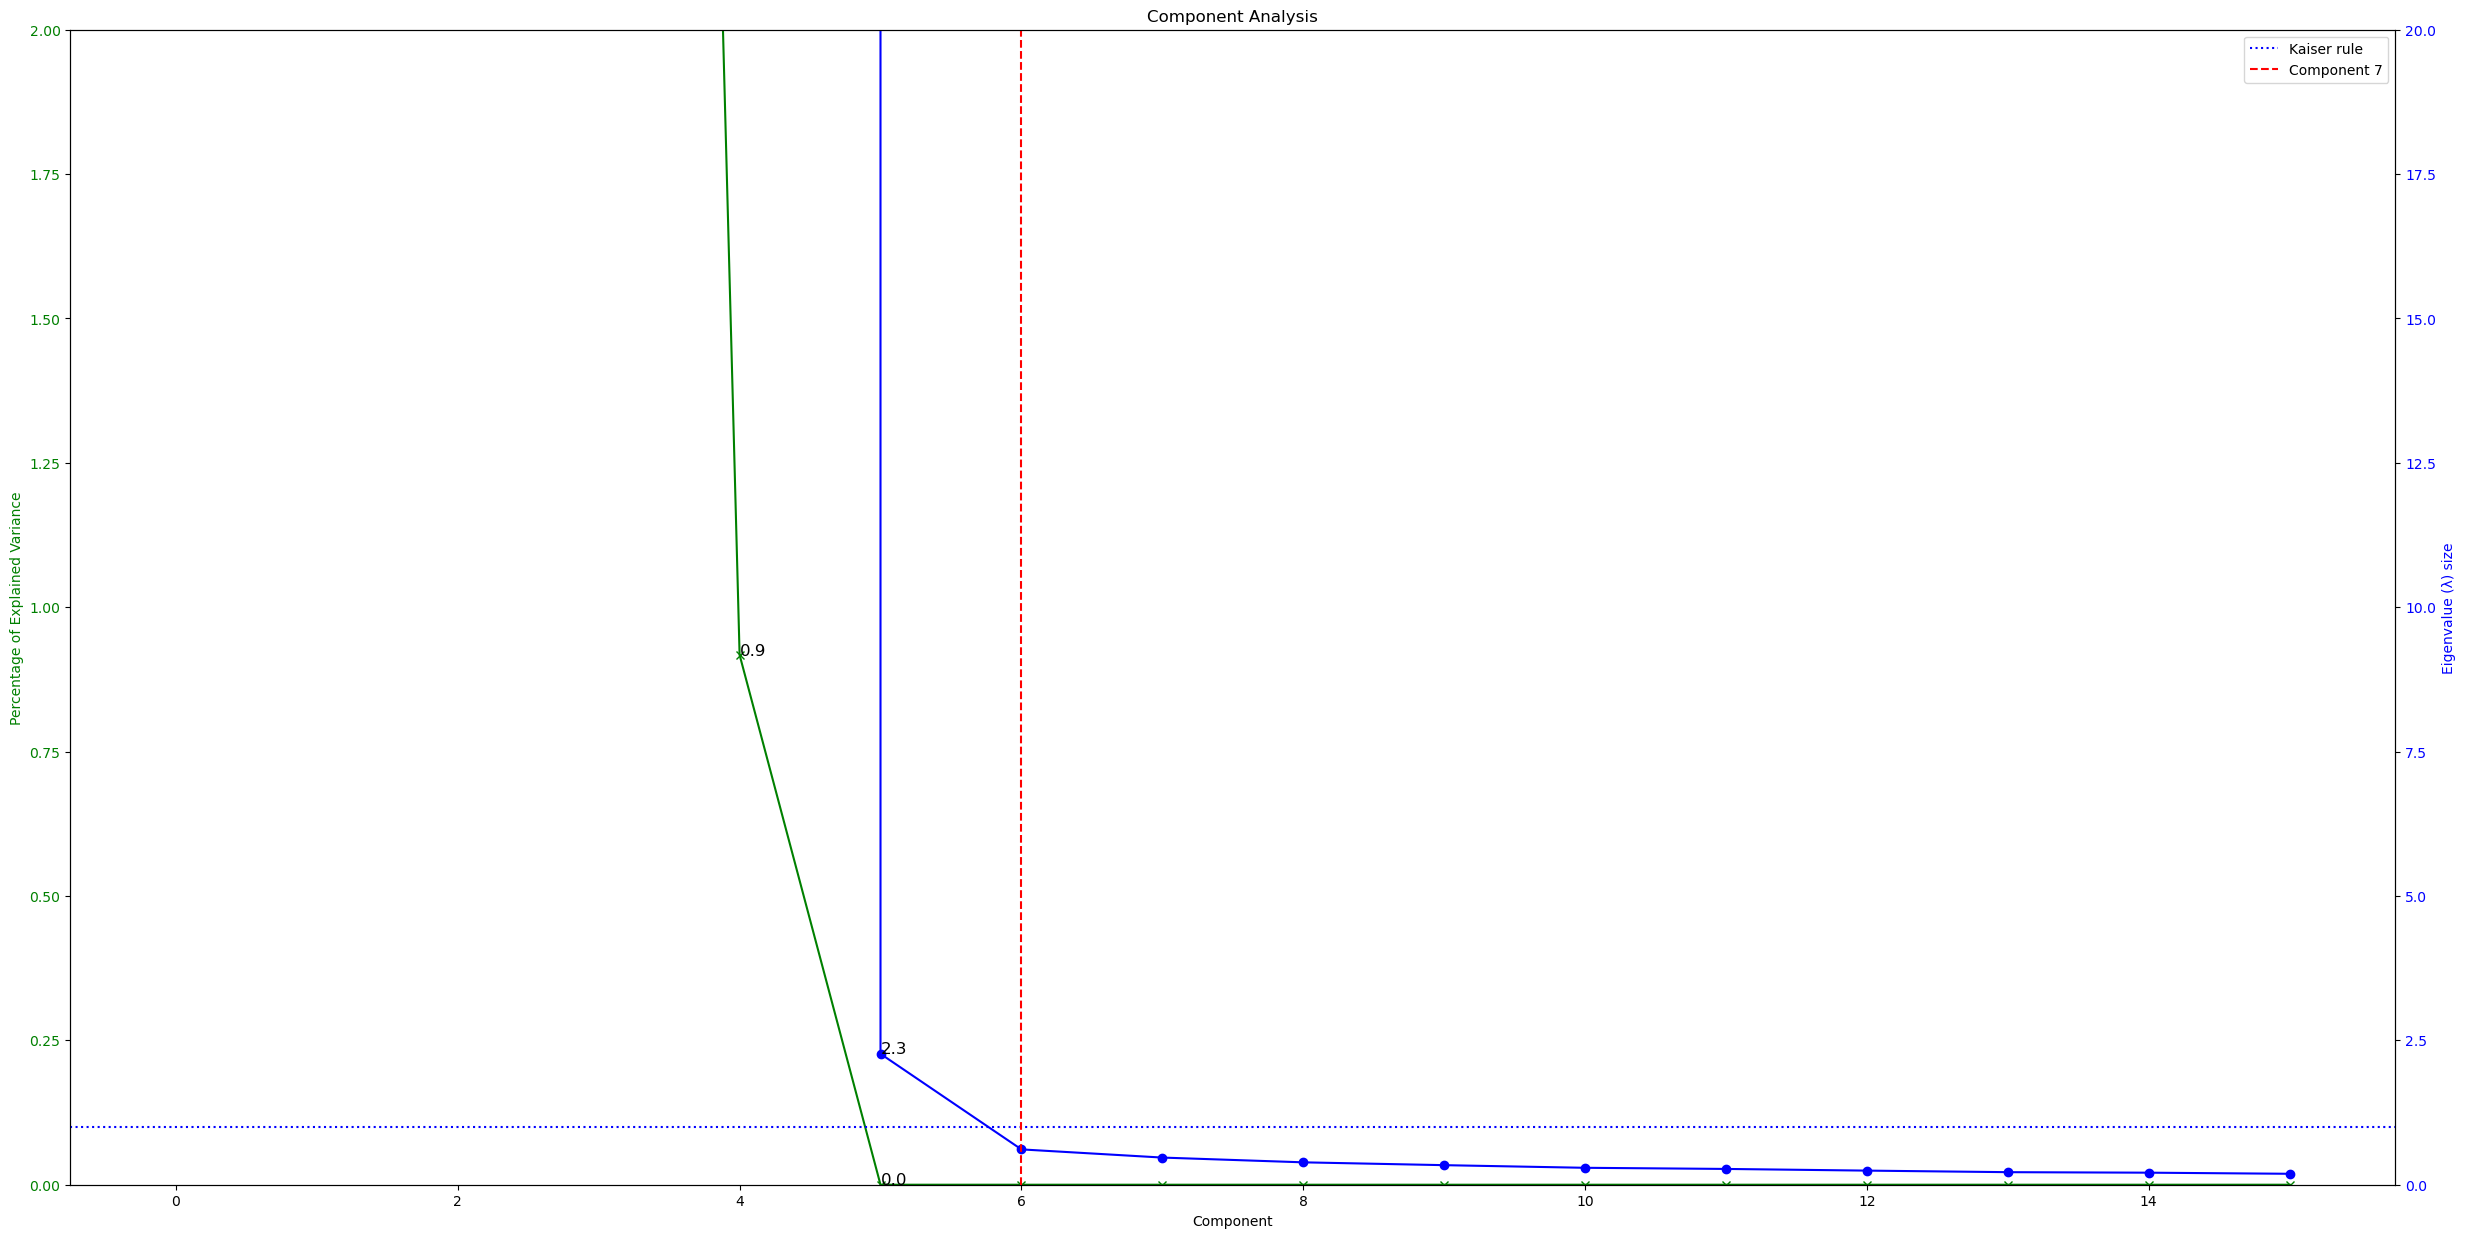

Amount of variance explained by 6 components s.t. λ_component > 1: 99.89999999999999%


In [16]:
# Linear PCA
pca = PCA(n_components=16, svd_solver="full")
pca_results = pca.fit_transform(train_samples)

color_var = "#008000"
color_eig = "#0000FF"
cutoff = 1
ylim = 2
fig, ax_var = plt.subplots(figsize=(30,15))
ax_eig = ax_var.twinx()
ax_var.set_xlabel("Component")
ax_var.set_title("Component Analysis")
ax_var.set_ylim(0, ylim)
ax_eig.set_ylim(0, ylim * 10)

ax_var.plot(pca.explained_variance_ratio_ * 100, marker="x", color=color_var)
ax_var.set_ylabel('Percentage of Explained Variance', color=color_var)
ax_var.tick_params(axis="y", labelcolor=color_var)

ax_eig.plot(pca.explained_variance_, marker="o", color=color_eig)
ax_eig.set_ylabel("Eigenvalue (λ) size", color=color_eig)
ax_eig.tick_params(axis="y", labelcolor=color_eig)
ax_eig.axhline(y=cutoff, linestyle=":", label="Kaiser rule", color=color_eig)

intersection = np.argwhere(np.diff(np.sign(cutoff - pca.explained_variance_))).flatten()
if len(intersection) == 0:
    num_components = len(pca.explained_variance_)
else:
    num_components = intersection[0] + 1
    ax_eig.axvline(x=num_components, linestyle="dashed", label="Component %d" %(num_components + 1), color="red")

linear_pca = PCA(n_components=num_components, svd_solver="full")
### Use these!
linear_pca_results_train = linear_pca.fit_transform(train_samples)
linear_pca_results_test = linear_pca.transform(test_samples)
### Use these!

_sum = 0
for index in range(num_components):
    if len(intersection) > 0:
        _sum = _sum + (pca.explained_variance_ratio_[index] * 100).round(1)
    if pca.explained_variance_ratio_[index] * 100 <= ylim:
        ax_var.text(index, pca.explained_variance_ratio_[index] * 100, (pca.explained_variance_ratio_[index] * 100).round(1), size=12)
    if pca.explained_variance_[index] <= ylim * 10:
        ax_eig.text(index, pca.explained_variance_[index], pca.explained_variance_[index].round(1), size=12)

ax_eig.legend(loc="upper right")
plt.show()
print("Amount of variance explained by " + str(num_components) + " components s.t. λ_component > 1: " + str(min(100, _sum)) + "%")

With all of our variance being able to be almost entirely explained in just a half-dozen components (as compared to our original 66 dimensions!), we can now move on to describing the final dataset which we shall be using, and then determine a metric we want to use to measure the overall performance of our models.

In [17]:
print(train_samples.columns)
train_samples.head()

Index(['cap-shape_0', 'cap-shape_1', 'cap-surface_1', 'cap-surface_2',
       'cap-surface_3', 'cap-color_2', 'cap-color_3', 'odor_0', 'odor_1',
       'odor_2', 'gill-color_0', 'gill-color_2', 'gill-color_3',
       'stalk-root_2', 'stalk-root_3', 'stalk-root_4', 'stalk-root_5',
       'stalk-surface-above-ring_1', 'stalk-surface-above-ring_2',
       'stalk-surface-above-ring_3', 'stalk-surface-below-ring_1',
       'stalk-surface-below-ring_2', 'stalk-surface-below-ring_3',
       'stalk-surface-below-ring_4', 'stalk-color-above-ring_0',
       'stalk-color-above-ring_1', 'stalk-color-above-ring_2',
       'stalk-color-above-ring_3', 'stalk-color-below-ring_0',
       'stalk-color-below-ring_1', 'stalk-color-below-ring_2',
       'stalk-color-below-ring_3', 'veil-color_1', 'veil-color_2',
       'veil-color_3', 'ring-number_1', 'ring-number_2', 'ring-number_3',
       'ring-type_1', 'ring-type_2', 'ring-type_3', 'ring-type_4',
       'ring-type_5', 'spore-print-color_1', 'spore-prin

,cap-shape_0,cap-shape_1,cap-surface_1,cap-surface_2,cap-surface_3,cap-color_2,cap-color_3,odor_0,odor_1,odor_2,...,spore-print-color_2,population,habitat_0,habitat_1,habitat_2,veil-color_1__veil-color_2__veil-color_3__veil-color_4__spore-print-color_0__spore-print-color_1__spore-print-color_2__spore-print-color_3,stalk-surface-above-ring_1__stalk-surface-above-ring_2__stalk-surface-above-ring_3__stalk-surface-above-ring_4__ring-type_1__ring-type_2__ring-type_3__ring-type_4__ring-type_5,stalk-surface-below-ring_1__stalk-surface-below-ring_2__stalk-surface-below-ring_3__stalk-surface-below-ring_4__ring-type_1__ring-type_2__ring-type_3__ring-type_4__ring-type_5,stalk-root_1__stalk-root_2__stalk-root_3__stalk-root_4__stalk-root_5__ring-type_1__ring-type_2__ring-type_3__ring-type_4__ring-type_5,stalk-root_1__stalk-root_2__stalk-root_3__stalk-root_4__stalk-root_5__spore-print-color_0__spore-print-color_1__spore-print-color_2__spore-print-color_3
5997,0,0,1,0,0,0,1,0,0,0,...,0,1,0,0,1,1829,8123,8123,8123,5691
5679,0,0,1,0,0,1,0,0,0,0,...,1,2,0,1,0,2159,7166,6619,6408,5976
2228,0,0,1,0,0,1,1,0,0,0,...,1,1,0,0,1,4871,3686,3272,3515,3712
1722,0,0,0,1,0,1,0,0,0,0,...,0,3,0,1,1,6475,6836,7893,1538,1586
4029,0,0,1,0,0,1,1,0,0,1,...,0,4,0,0,1,483,891,563,2147,2151


Concerning the dataset: the vast majority of the features, totalling 66, are simply existing features that have been split out via an appropriate encoding algorithm. For instance, cap shape, cap surface, and cap color already existed in the original dataset and have been split out into sets of either dummy or one-hot encoded features, depending on applicability. There are, however, several exceptions: the crossed features (noted by their long-winded column names) represent amalgamated features that showed a strong linear relationship with each other when viewed under a Pearson correlation study. While the team writing this paper does not have the relevant domain knowledge to ascribe formalized meaning to these relationships, we can confidently state that they represent a more complex relationship that evidences a property of mushrooms in general, much like how crossing most bird's coloration & size would end up being representative of their sex.
From this dataset, then, we build our final dataset: a set of 6 components created from a linear PCA that explain ~100% of the variance in the original dataset, but with only ~9% of the number of features/dimensions. While these components and their relationship to the original features is opaque and not directly interpretable (a problem with many DL/ML systems in general), we do have confidence through our eigenvalue analysis and application of the Kaiser rule that these components to accurately represent the original dataset and can be used to evaluate a model's performance in the classification of whether our mushroom is poisonous or edible.

But even with the dataset built, we must have a metric which we weigh the performance of a model on it with. Accuracy is a common, if often inappropriate measurement, and we believe we can improve upon using solely this metric. In our case, our dataset is exactly balanced, meaning that accuracy could be a useful metric for determining how often we predict the correct answer, however when considering the meaning of the dataset and what we are trying to classify (whether a mushroom is poisonous or edible), additional metrics can come in handy.
For example, a false negative for a mushroom being poisonous could have disastrous consequences for the person relying on the classification: with this in mind, recall/sensitivity would be an appropriate metric, as we want to minimize the false negative rate as much as possible. However, we still want to make sure that we are preforming well with respect to the true positive class, as a false positive could still have significant consequences in the case of a false edibility classification. For this reason, we can also utilize the precision metric, and take an aggregate performance measure of both of these (with our recall/sensitivity being somewhat more important that our precision) through an F1 score.
With all of these 4 metric combined, we should have a very strong foundation for determining the general performance and suitability of our models on our dataset.

      cap-shape_0  cap-shape_1  cap-surface_1  cap-surface_2  cap-surface_3  \
5997            0            0              1              0              0   
5679            0            0              1              0              0   
2228            0            0              1              0              0   
1722            0            0              0              1              0   
4029            0            0              1              0              0   
...           ...          ...            ...            ...            ...   
6596            0            1              0              0              1   
5348            0            0              0              0              1   
8017            1            0              0              1              0   
7081            0            0              1              0              0   
7626            0            0              0              0              1   

      cap-color_2  cap-color_3  odor_0  odor_1  odo

# Deep Network

In [61]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Flatten


#model = Sequential()
#model.add(Dense(500,input_dim=54,activation='relu'))
#model.add(Dense(10,input_dim=54,activation='relu'))
#model.add(Dense(200, activation="relu"))
#model.add(Dense(200, activation="relu"))
#model.add(Dense(200, activation="relu"))
#model.add(Dense(10, activation="softmax"))
#model.add(Dense(1,activation='softmax'))



model = Sequential()
input_ = Input(shape=(54,))
hidden1 = Dense(500, activation="relu")(input_)
hidden2 = Dense(200, activation="relu")(hidden1)
hidden3 = Dense(200, activation="relu")(hidden2)
concat = Concatenate()([input_, hidden3])
output = Dense(1, activation="softmax")(concat)
model = Model(inputs=[input_], outputs=[output])




#model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.compile(optimizer='sgd', loss='mean_squared_error', metrics=['accuracy'])
model.summary()


print(Model)
plot_model(
    model, to_file='model.png', show_shapes=True, show_layer_names=True,
    rankdir='LR', expand_nested=False, dpi=96
)


Model: "model_13"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_17 (InputLayer)          [(None, 54)]         0           []                               
                                                                                                  
 dense_73 (Dense)               (None, 500)          27500       ['input_17[0][0]']               
                                                                                                  
 dense_74 (Dense)               (None, 200)          100200      ['dense_73[0][0]']               
                                                                                                  
 dense_75 (Dense)               (None, 200)          40200       ['dense_74[0][0]']               
                                                                                           

In [45]:

model.fit(train_samples, train_target, epochs=150, verbose=2)

model.evaluate(test_samples, test_target)





Epoch 1/150
204/204 - 1s - loss: 0.5179 - accuracy: 0.4821 - 860ms/epoch - 4ms/step
Epoch 2/150
204/204 - 0s - loss: 0.5179 - accuracy: 0.4821 - 380ms/epoch - 2ms/step
Epoch 3/150
204/204 - 0s - loss: 0.5179 - accuracy: 0.4821 - 412ms/epoch - 2ms/step
Epoch 4/150
204/204 - 0s - loss: 0.5179 - accuracy: 0.4821 - 382ms/epoch - 2ms/step
Epoch 5/150
204/204 - 0s - loss: 0.5179 - accuracy: 0.4821 - 392ms/epoch - 2ms/step
Epoch 6/150
204/204 - 0s - loss: 0.5179 - accuracy: 0.4821 - 393ms/epoch - 2ms/step
Epoch 7/150
204/204 - 0s - loss: 0.5179 - accuracy: 0.4821 - 383ms/epoch - 2ms/step
Epoch 8/150
204/204 - 0s - loss: 0.5179 - accuracy: 0.4821 - 387ms/epoch - 2ms/step
Epoch 9/150
204/204 - 0s - loss: 0.5179 - accuracy: 0.4821 - 388ms/epoch - 2ms/step
Epoch 10/150
204/204 - 0s - loss: 0.5179 - accuracy: 0.4821 - 385ms/epoch - 2ms/step
Epoch 11/150
204/204 - 0s - loss: 0.5179 - accuracy: 0.4821 - 387ms/epoch - 2ms/step
Epoch 12/150
204/204 - 0s - loss: 0.5179 - accuracy: 0.4821 - 387ms/epoch 

Epoch 98/150
204/204 - 0s - loss: 0.5179 - accuracy: 0.4821 - 386ms/epoch - 2ms/step
Epoch 99/150
204/204 - 0s - loss: 0.5179 - accuracy: 0.4821 - 383ms/epoch - 2ms/step
Epoch 100/150
204/204 - 0s - loss: 0.5179 - accuracy: 0.4821 - 385ms/epoch - 2ms/step
Epoch 101/150
204/204 - 0s - loss: 0.5179 - accuracy: 0.4821 - 383ms/epoch - 2ms/step
Epoch 102/150
204/204 - 0s - loss: 0.5179 - accuracy: 0.4821 - 382ms/epoch - 2ms/step
Epoch 103/150
204/204 - 0s - loss: 0.5179 - accuracy: 0.4821 - 402ms/epoch - 2ms/step
Epoch 104/150
204/204 - 0s - loss: 0.5179 - accuracy: 0.4821 - 390ms/epoch - 2ms/step
Epoch 105/150
204/204 - 0s - loss: 0.5179 - accuracy: 0.4821 - 389ms/epoch - 2ms/step
Epoch 106/150
204/204 - 0s - loss: 0.5179 - accuracy: 0.4821 - 383ms/epoch - 2ms/step
Epoch 107/150
204/204 - 0s - loss: 0.5179 - accuracy: 0.4821 - 398ms/epoch - 2ms/step
Epoch 108/150
204/204 - 0s - loss: 0.5179 - accuracy: 0.4821 - 391ms/epoch - 2ms/step
Epoch 109/150
204/204 - 0s - loss: 0.5179 - accuracy: 0.

[0.5181537866592407, 0.4818461537361145]

# Wide Network (Logistic Regression)

In [68]:

model = Sequential()
model.add( Dense(1, activation='softmax',  input_dim=54))
model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])



model.summary()


Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_80 (Dense)            (None, 1)                 55        
                                                                 
Total params: 55
Trainable params: 55
Non-trainable params: 0
_________________________________________________________________


In [69]:

model.fit(train_samples, train_target, epochs=150, verbose=2)

model.evaluate(test_samples, test_target)

Epoch 1/150
204/204 - 1s - loss: 0.0000e+00 - accuracy: 0.4821 - 550ms/epoch - 3ms/step
Epoch 2/150
204/204 - 0s - loss: 0.0000e+00 - accuracy: 0.4821 - 182ms/epoch - 892us/step
Epoch 3/150
204/204 - 0s - loss: 0.0000e+00 - accuracy: 0.4821 - 185ms/epoch - 907us/step
Epoch 4/150
204/204 - 0s - loss: 0.0000e+00 - accuracy: 0.4821 - 188ms/epoch - 922us/step
Epoch 5/150
204/204 - 0s - loss: 0.0000e+00 - accuracy: 0.4821 - 183ms/epoch - 897us/step
Epoch 6/150
204/204 - 0s - loss: 0.0000e+00 - accuracy: 0.4821 - 183ms/epoch - 897us/step
Epoch 7/150
204/204 - 0s - loss: 0.0000e+00 - accuracy: 0.4821 - 183ms/epoch - 897us/step
Epoch 8/150
204/204 - 0s - loss: 0.0000e+00 - accuracy: 0.4821 - 183ms/epoch - 897us/step
Epoch 9/150
204/204 - 0s - loss: 0.0000e+00 - accuracy: 0.4821 - 183ms/epoch - 897us/step
Epoch 10/150
204/204 - 0s - loss: 0.0000e+00 - accuracy: 0.4821 - 184ms/epoch - 902us/step
Epoch 11/150
204/204 - 0s - loss: 0.0000e+00 - accuracy: 0.4821 - 185ms/epoch - 907us/step
Epoch 12/1

Epoch 92/150
204/204 - 0s - loss: 0.0000e+00 - accuracy: 0.4821 - 186ms/epoch - 912us/step
Epoch 93/150
204/204 - 0s - loss: 0.0000e+00 - accuracy: 0.4821 - 185ms/epoch - 907us/step
Epoch 94/150
204/204 - 0s - loss: 0.0000e+00 - accuracy: 0.4821 - 184ms/epoch - 902us/step
Epoch 95/150
204/204 - 0s - loss: 0.0000e+00 - accuracy: 0.4821 - 187ms/epoch - 917us/step
Epoch 96/150
204/204 - 0s - loss: 0.0000e+00 - accuracy: 0.4821 - 184ms/epoch - 902us/step
Epoch 97/150
204/204 - 0s - loss: 0.0000e+00 - accuracy: 0.4821 - 185ms/epoch - 907us/step
Epoch 98/150
204/204 - 0s - loss: 0.0000e+00 - accuracy: 0.4821 - 188ms/epoch - 922us/step
Epoch 99/150
204/204 - 0s - loss: 0.0000e+00 - accuracy: 0.4821 - 184ms/epoch - 902us/step
Epoch 100/150
204/204 - 0s - loss: 0.0000e+00 - accuracy: 0.4821 - 187ms/epoch - 917us/step
Epoch 101/150
204/204 - 0s - loss: 0.0000e+00 - accuracy: 0.4821 - 187ms/epoch - 917us/step
Epoch 102/150
204/204 - 0s - loss: 0.0000e+00 - accuracy: 0.4821 - 186ms/epoch - 912us/s

[0.0, 0.4818461537361145]

# Additional Network

In [72]:
model = Sequential()
input_ = Input(shape=(54,))
hidden1 = Dense(8, activation="relu")(input_)
hidden2 = Dense(8, activation="relu")(hidden1)
hidden3 = Dense(8, activation="relu")(hidden2)
concat = Concatenate()([input_, hidden3])
output = Dense(1, activation="softmax")(concat)
model = Model(inputs=[input_], outputs=[output])




#model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
model.summary()

Model: "model_14"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_20 (InputLayer)          [(None, 54)]         0           []                               
                                                                                                  
 dense_81 (Dense)               (None, 8)            440         ['input_20[0][0]']               
                                                                                                  
 dense_82 (Dense)               (None, 8)            72          ['dense_81[0][0]']               
                                                                                                  
 dense_83 (Dense)               (None, 8)            72          ['dense_82[0][0]']               
                                                                                           

In [73]:

model.fit(train_samples, train_target, epochs=150, verbose=2)

model.evaluate(test_samples, test_target)

Epoch 1/150
204/204 - 1s - loss: 0.5179 - accuracy: 0.4821 - 848ms/epoch - 4ms/step
Epoch 2/150
204/204 - 0s - loss: 0.5179 - accuracy: 0.4821 - 262ms/epoch - 1ms/step
Epoch 3/150
204/204 - 0s - loss: 0.5179 - accuracy: 0.4821 - 266ms/epoch - 1ms/step
Epoch 4/150
204/204 - 0s - loss: 0.5179 - accuracy: 0.4821 - 254ms/epoch - 1ms/step
Epoch 5/150
204/204 - 0s - loss: 0.5179 - accuracy: 0.4821 - 264ms/epoch - 1ms/step
Epoch 6/150
204/204 - 0s - loss: 0.5179 - accuracy: 0.4821 - 262ms/epoch - 1ms/step
Epoch 7/150
204/204 - 0s - loss: 0.5179 - accuracy: 0.4821 - 254ms/epoch - 1ms/step
Epoch 8/150
204/204 - 0s - loss: 0.5179 - accuracy: 0.4821 - 252ms/epoch - 1ms/step
Epoch 9/150
204/204 - 0s - loss: 0.5179 - accuracy: 0.4821 - 253ms/epoch - 1ms/step
Epoch 10/150
204/204 - 0s - loss: 0.5179 - accuracy: 0.4821 - 274ms/epoch - 1ms/step
Epoch 11/150
204/204 - 0s - loss: 0.5179 - accuracy: 0.4821 - 259ms/epoch - 1ms/step
Epoch 12/150
204/204 - 0s - loss: 0.5179 - accuracy: 0.4821 - 256ms/epoch 

Epoch 98/150
204/204 - 0s - loss: 0.5179 - accuracy: 0.4821 - 254ms/epoch - 1ms/step
Epoch 99/150
204/204 - 0s - loss: 0.5179 - accuracy: 0.4821 - 255ms/epoch - 1ms/step
Epoch 100/150
204/204 - 0s - loss: 0.5179 - accuracy: 0.4821 - 256ms/epoch - 1ms/step
Epoch 101/150
204/204 - 0s - loss: 0.5179 - accuracy: 0.4821 - 256ms/epoch - 1ms/step
Epoch 102/150
204/204 - 0s - loss: 0.5179 - accuracy: 0.4821 - 256ms/epoch - 1ms/step
Epoch 103/150
204/204 - 0s - loss: 0.5179 - accuracy: 0.4821 - 253ms/epoch - 1ms/step
Epoch 104/150
204/204 - 0s - loss: 0.5179 - accuracy: 0.4821 - 253ms/epoch - 1ms/step
Epoch 105/150
204/204 - 0s - loss: 0.5179 - accuracy: 0.4821 - 254ms/epoch - 1ms/step
Epoch 106/150
204/204 - 0s - loss: 0.5179 - accuracy: 0.4821 - 253ms/epoch - 1ms/step
Epoch 107/150
204/204 - 0s - loss: 0.5179 - accuracy: 0.4821 - 255ms/epoch - 1ms/step
Epoch 108/150
204/204 - 0s - loss: 0.5179 - accuracy: 0.4821 - 255ms/epoch - 1ms/step
Epoch 109/150
204/204 - 0s - loss: 0.5179 - accuracy: 0.

[0.5181537866592407, 0.4818461537361145]


___


## Combining Crossed Linear Classifier and Deep Embeddings
Now its just a matter of setting the wide and deep columns for tensorflow. After which, we can use the combined classifier!

Wide and deep models can have really interesting and useful properties so they are great to keep in mind when selecting an architecture. Some of the hyperparameters that are specific to this are:
- which features to cross together, typically you only want to cross columns you think are important to be connected--they somehow might create new knowledge by combining.
- the size of the dense feature embeddings. This can be difficult to set, but one common setting is $log_2(N)$ or $\sqrt{N}$ where $N$ is the total number of uniques values.

This code should really work unmodified, assuming we can provide the correct inputs. All of our data is categorical, but we must generate array of crossed features if we have time, or we could attempt to use DNNLinearCombinedClassifier which performs the same operation

In [70]:

df_train = train_samples
df_test = test_samples

print(df_train.info())
print(df_test.info())


encoders = dict() # save each encoder in dictionary



categorical_headers = ['cap-shape','cap-surface','cap-color',
                       'bruises','gill-attachment','gill-spacing','gill-size','gill-color',
                      'stalk-shape', 'stalk-root', 'stalk-surface-above-ring', 'stalk-surface-below-ring',
                      'stalk-color-above-ring', 'stalk-color-below-ring', 'veil-type', 'veil-color', 'ring-number',
                      'ring-type', 'spore-print-color', 'population', 'habitat']


for col in categorical_headers+['class']:
    #df_train[col] = df_train[col].str.strip()
    #df_test[col] = df_test[col].str.strip()
    # integer encode strings that are features
    encoders[col] = LabelEncoder() # save the encoder
    df_train[col+'_int'] = encoders[col].fit_transform(df_train[col])
    df_test[col+'_int'] = encoders[col].transform(df_test[col])


# Train a model only using crossed values
# get crossed columns
X_train_crossed = df_train[cross_col_df_names].to_numpy()
X_test_crossed = df_test[cross_col_df_names].to_numpy()

crossed_outputs = [] # this is where we will keep track of output of each branch

input_crossed = Input(shape=(X_train_crossed.shape[1],), dtype='int64', name='categorical')
for idx,col in enumerate(cross_col_df_names):
    
    # track what the maximum integer value will be for this variable
    # which is the same as the number of categories
    N = max(df_train[col].max(),df_test[col].max())+1
    N = len(encoders[col].classes_)
    N_reduced = int(np.sqrt(N))
    
    # this line of code does this: input_branch[:,idx]
    x = tf.gather(input_crossed, idx, axis=1)
    
    # now use an embedding to deal with integers as if they were one hot encoded
    x = Embedding(input_dim=N, 
                  output_dim=N_reduced, 
                  input_length=1, name=col+'_embed')(x)
    
    # save these outputs to concatenate later
    crossed_outputs.append(x)
    

# now concatenate the outputs and add a fully connected layer
wide_branch = concatenate(crossed_outputs, name='concat_1')
wide_branch = Dense(units=1,activation='sigmoid', name='combined')(wide_branch)

model = Model(inputs=input_crossed, outputs=wide_branch)

model.compile(optimizer='sgd',
              loss='mean_squared_error',
              metrics=['accuracy'])

model.fit(X_train_crossed,
        y_train, epochs=10, batch_size=32, verbose=1)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6499 entries, 5997 to 7626
Data columns (total 54 columns):
 #   Column                                                                                                                                                                           Non-Null Count  Dtype
---  ------                                                                                                                                                                           --------------  -----
 0   cap-shape_0                                                                                                                                                                      6499 non-null   int64
 1   cap-shape_1                                                                                                                                                                      6499 non-null   int64
 2   cap-surface_1                                                        

KeyError: 'cap-shape'

In [71]:
# bonus: we can keep training, picking up where we left of (no reinitialization)
model.fit(X_train_crossed,
        y_train, epochs=10, batch_size=32, verbose=1)

NameError: name 'y_train' is not defined

In [ ]:
yhat = np.round(model.predict(X_test_crossed))
print(mt.confusion_matrix(y_test,yhat))
print(mt.classification_report(y_test,yhat))

In [ ]:
# you will need to install pydot properly on your machine to get this running
plot_model(
    model, to_file='model.png', show_shapes=True, show_layer_names=True,
    rankdir='LR', expand_nested=False, dpi=96
)

In [ ]:
# get crossed columns
X_train_crossed = df_train[cross_col_df_names].to_numpy()
X_test_crossed = df_test[cross_col_df_names].to_numpy()

# save categorical features
X_train_cat = df_train[categorical_headers_ints].to_numpy() 
X_test_cat = df_test[categorical_headers_ints].to_numpy() 

# and save off the numeric features
X_train_num =  df_train[numeric_headers].to_numpy()
X_test_num = df_test[numeric_headers].to_numpy()


# we need to create separate lists for each branch
crossed_outputs = []

# CROSSED DATA INPUT
input_crossed = Input(shape=(X_train_crossed.shape[1],), dtype='int64', name='wide_inputs')
for idx,col in enumerate(cross_col_df_names):
    
    # track what the maximum integer value will be for this variable
    # which is the same as the number of categories
    N = max(df_train[col].max(),df_test[col].max())+1
    N = len(encoders[col].classes_)
    N_reduced = int(np.sqrt(N))
    
    
    # this line of code does this: input_branch[:,idx]
    x = tf.gather(input_crossed, idx, axis=1)
    
    # now use an embedding to deal with integers as if they were one hot encoded
    x = Embedding(input_dim=N, 
                  output_dim=N_reduced, 
                  input_length=1, name=col+'_embed')(x)
    
    # save these outputs to concatenate later
    crossed_outputs.append(x)
    

# now concatenate the outputs and add a fully connected layer
wide_branch = concatenate(crossed_outputs, name='wide_concat')

# reset this input branch
all_deep_branch_outputs = []

# CATEGORICAL DATA INPUT
input_cat = Input(shape=(X_train_cat.shape[1],), dtype='int64', name='categorical_input')
for idx,col in enumerate(categorical_headers_ints):
    
    # track what the maximum integer value will be for this variable
    # which is the same as the number of categories
    N = max(df_train[col].max(),df_test[col].max())+1
    N_reduced = int(np.sqrt(N))
    
    # this line of code does this: input_branch[:,idx]
    x = tf.gather(input_cat, idx, axis=1)
    
    # now use an embedding to deal with integers as if they were one hot encoded
    x = Embedding(input_dim=N, 
                  output_dim=N_reduced, 
                  input_length=1, name=col+'_embed')(x)
    
    # save these outputs to concatenate later
    all_deep_branch_outputs.append(x)
    
# NUMERIC DATA INPUT
# create dense input branch for numeric
input_num = Input(shape=(X_train_num.shape[1],), name='numeric')
x_dense = Dense(units=20, activation='relu',name='num_1')(input_num)
    
all_deep_branch_outputs.append(x_dense)


# merge the deep branches together
deep_branch = concatenate(all_deep_branch_outputs,name='concat_embeds')
deep_branch = Dense(units=50,activation='relu', name='deep1')(deep_branch)
deep_branch = Dense(units=25,activation='relu', name='deep2')(deep_branch)
deep_branch = Dense(units=10,activation='relu', name='deep3')(deep_branch)
    
# merge the deep and wide branch
final_branch = concatenate([wide_branch, deep_branch],
                           name='concat_deep_wide')
final_branch = Dense(units=1,activation='sigmoid',
                     name='combined')(final_branch)

model = Model(inputs=[input_crossed,input_cat,input_num], 
              outputs=final_branch)



In [ ]:
# you will need to install pydot properly on your machine to get this running
plot_model(
    model, to_file='model.png', show_shapes=True, show_layer_names=True,
    rankdir='LR', expand_nested=False, dpi=96
)
# model.summary()

In [ ]:
%%time

model.compile(optimizer='adagrad',
              loss='mean_squared_error',
              metrics=['accuracy'])

# lets also add the history variable to see how we are doing
# and lets add a validation set to keep track of our progress
history = model.fit([X_train_crossed,X_train_cat,X_train_num],
                    y_train, 
                    epochs=15, 
                    batch_size=32, 
                    verbose=1, 
                    validation_data = ([X_test_crossed,X_test_cat,X_test_num],y_test))

In [ ]:
history = model.fit([X_train_crossed,X_train_cat,X_train_num],
                    y_train, 
                    epochs=50, 
                    batch_size=32, 
                    verbose=0, 
                    validation_data = ([X_test_crossed,X_test_cat,X_test_num],y_test))

In [ ]:
yhat = np.round(model.predict([X_test_crossed,X_test_cat,X_test_num]))
print(mt.confusion_matrix(y_test,yhat))
print(mt.classification_report(y_test,yhat))

In [ ]:
%matplotlib inline

plt.figure(figsize=(10,4))
plt.subplot(2,2,1)
plt.plot(history.history['accuracy'])

plt.ylabel('Accuracy %')
plt.title('Training')
plt.subplot(2,2,2)
plt.plot(history.history['val_accuracy'])
plt.title('Validation')

plt.subplot(2,2,3)
plt.plot(history.history['loss'])
plt.ylabel('Training Loss')
plt.xlabel('epochs')

plt.subplot(2,2,4)
plt.plot(history.history['val_loss'])
plt.xlabel('epochs')